In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install tensorflow==1.15
#!pip install "tensorflow_hub>=0.6.0" 

## Preprocessing

### Importing Libraries

In [ ]:
!pip install chart_studio

In [ ]:
#importing all libraries
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import os
import re
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import itertools
from scipy import stats
from ast import literal_eval
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten,Permute,concatenate, multiply, Lambda, Concatenate,RepeatVector, Conv1D, MaxPooling1D,Bidirectional,TimeDistributed,CuDNNLSTM,Reshape,Conv2D,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')

In [ ]:
!pip install nltk
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem.wordnet import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import gensim
import json


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import keras.utils
from keras import utils as np_utils

#Keras Tokenizer just replaces certain punctuation characters and splits on the remaining space character.
#NLTK Tokenizer uses the Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank. 

In [ ]:

WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

### Creating a dataframe from the transcript file

In [ ]:
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all.csv', sep=',')
    print("File was created")
    return all_participants

In [ ]:
#loading the data
data_path = "/content/drive/My Drive/transcripts/"
all_participants = transcripts_to_dataframe(data_path)

File was created


In [ ]:
all_participants.head(20)

,personId,question,answer
0,300,hi i'm ellie thanks for coming in today,
1,300,i was created to talk to people in a safe and ...,
2,300,think of me as a friend i don't judge i can't ...,
3,300,i'm here to learn about people and would love ...,
4,300,i'll ask a few questions to get us started and...,
5,300,how are you doing today,good
6,300,that's good,
7,300,where are you from originally,atlanta georgia
8,300,really,
9,300,why'd you move to l_a,um my parents are from here um


### Removing the stopwords and cleaning the data

In [ ]:
#https://www.kaggle.com/currie32/the-importance-of-cleaning-text

def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [ ]:
#creating a corpus with the words from the answers without stopwords given by the patients
all_participants_mix = all_participants.copy() # However, if you need the original list unchanged when the new list is modified, you can use copy() method. This is called shallow copy.
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)

In [ ]:
##creating a corpus with the words from the answers withstopwords given by the patients
# stopwords are ={what is , have,}
all_participants_mix_stopwords = all_participants.copy()
all_participants_mix_stopwords['answer'] = all_participants_mix_stopwords.apply(lambda row: text_to_wordlist(row.answer, remove_stopwords=False).split(), axis=1)


In [ ]:
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words)) #chain('ABC', 'DEF') --> A B C D E F
vocab_size = len(words)

### Getting the top common words used by the patients

In [ ]:
words

{'grant',
 'bumpy',
 'kn',
 'trophy',
 'karenina',
 'pretend',
 'stage',
 'ed',
 'merit',
 'spot',
 'acting',
 'diversion',
 'anaheim',
 'curtails',
 'mode',
 'town',
 'custody',
 'irritate',
 'barber',
 'energetic',
 'sweet',
 'blissed',
 'entertai',
 'ok',
 'producer',
 'brazil',
 'exploded',
 'shooting',
 'grind',
 'gnarly',
 'grinding',
 'cooking',
 'crack',
 'expert',
 'directorship',
 'res',
 'week',
 'since',
 'playful',
 'edge',
 'in',
 'good',
 'spay',
 'spill',
 'neurologist',
 'argu',
 'heritage',
 'l',
 'heaven',
 'foggy',
 'rockstar',
 'breakdown',
 'abbey',
 'pareos',
 'deceitful',
 'parent',
 'disappointment',
 'hippie',
 'physician',
 'achieve',
 'extraneous',
 'blue',
 'trainer',
 'hungary',
 'invol',
 'rein',
 'investing',
 'worsened',
 'accepts',
 'insightful',
 'master',
 'accounting',
 'severe',
 'got',
 'subject',
 'bitter',
 'next',
 'instruction',
 'canceling',
 'detail',
 'sigh',
 'breed',
 'huh',
 'discovered',
 'lackadaisical',
 'anyway',
 'pregnancy',
 'come

In [ ]:
words_stop = [w for w in all_participants_mix_stopwords['answer'].tolist()]
words_stop = set(itertools.chain(*words_stop))
vocab_size_stop = len(words_stop)

In [ ]:
words_stop

{'grant',
 'bumpy',
 'kn',
 'trophy',
 'karenina',
 'pretend',
 'stage',
 'ed',
 'merit',
 'spot',
 'acting',
 'diversion',
 'anaheim',
 'curtails',
 'mode',
 'town',
 'custody',
 'irritate',
 'barber',
 'energetic',
 'sweet',
 'blissed',
 'entertai',
 'ok',
 'producer',
 'brazil',
 'exploded',
 'shooting',
 'grind',
 'gnarly',
 'grinding',
 'cooking',
 'crack',
 'expert',
 'directorship',
 'res',
 'week',
 'since',
 'playful',
 'edge',
 'in',
 'good',
 'spay',
 'spill',
 'neurologist',
 'argu',
 'heritage',
 'l',
 'heaven',
 'foggy',
 'rockstar',
 'breakdown',
 'abbey',
 'pareos',
 'deceitful',
 'parent',
 'disappointment',
 'hippie',
 'physician',
 'achieve',
 'extraneous',
 'blue',
 'trainer',
 'hungary',
 'invol',
 'rein',
 'investing',
 'worsened',
 'accepts',
 'insightful',
 'master',
 'accounting',
 'severe',
 'got',
 'subject',
 'bitter',
 'next',
 'instruction',
 'canceling',
 'detail',
 'sigh',
 'breed',
 'huh',
 'discovered',
 'lackadaisical',
 'anyway',
 'pregnancy',
 'come

In [ ]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer']) # fit_on_texts creates the vocabulary index based on word frequency.
#The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word 

tokenizer.fit_on_sequences(all_participants_mix['answer']) #texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix.head(15)

#   why are the output as numbers when text_to_sequences is called?
# the Tokenizer stores everything in the word_index during fit_on_texts. Then, when calling the texts_to_sequences method, only the top num_words are considered.

,personId,question,answer,t_answer
0,300,hi i'm ellie thanks for coming in today,[],[]
1,300,i was created to talk to people in a safe and ...,[],[]
2,300,think of me as a friend i don't judge i can't ...,[],[]
3,300,i'm here to learn about people and would love ...,[],[]
4,300,i'll ask a few questions to get us started and...,[],[]
5,300,how are you doing today,[good],[16]
6,300,that's good,[],[]
7,300,where are you from originally,"[atlanta, georgia]","[1634, 1997]"
8,300,really,[],[]
9,300,why'd you move to l_a,"[um, parent, um]","[1, 131, 1]"


In [ ]:

windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size_stop)
tokenizer.fit_on_texts(all_participants_mix_stopwords['answer'])
tokenizer.fit_on_sequences(all_participants_mix_stopwords['answer'])

all_participants_mix_stopwords['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix_stopwords['answer'])
all_participants_mix_stopwords.head(15)

,personId,question,answer,t_answer
0,300,hi i'm ellie thanks for coming in today,[],[]
1,300,i was created to talk to people in a safe and ...,[],[]
2,300,think of me as a friend i don't judge i can't ...,[],[]
3,300,i'm here to learn about people and would love ...,[],[]
4,300,i'll ask a few questions to get us started and...,[],[]
5,300,how are you doing today,[good],[42]
6,300,that's good,[],[]
7,300,where are you from originally,"[atlanta, georgia]","[1727, 2089]"
8,300,really,[],[]
9,300,why'd you move to l_a,"[um, my, parent, are, from, here, um]","[5, 12, 205, 37, 69, 113, 5]"


In [ ]:
word_index = tokenizer.word_index
word_size = len(word_index)
print(word_index["sad"])


654


# Data Augmentation of the tokenized words to improve model performance

In [ ]:
#windows_size = WINDOWS_SIZE
#cont = 0
#word_index = tokenizer
#phrases_lp = pd.DataFrame(columns=['personId','answer','t_answer'])
#answers = all_participants_mix.groupby('personId').agg('sum', axis=1)

#for p in answers.iterrows():      
    #words = p[1]["answer"]
    #size = len(words)
    #word_tokens = p[1]["t_answer"]
 
    #for i in range(size):
        #sentence = words[i:min(i+windows_size,size)]  
        #tokens = word_tokens[i:min(i+windows_size,size)]  
        #phrases_lp.loc[cont] = [p[0], sentence, tokens]
        #cont = cont + 1

In [ ]:
#phrases_lp.head()
#phrases_lp.to_csv('/content/drive/My Drive/Final-year-project-Phase2/phrases_lp.csv', sep='\t')
#print("File was created")

In [ ]:
#phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
#phrases_lp.drop(phrases_lp[phrases_lp["t_answer"].map(len) > 10].index, inplace = True)


In [ ]:
#phrases_lp_stop.to_csv('/content/drive/My Drive/Final-year-project-Phase2/phrases_lp_stop.csv', sep='\t')
#print("File was created")

### Loading the data augmented dataset

In [ ]:
phrases_lp = pd.read_csv('/content/drive/My Drive/Final-year-project-Phase 2/phrases_lp.csv', sep='\t', converters={"t_answer": literal_eval}) 
phrases_lp.head(15)


,Unnamed: 0,personId,answer,t_answer
0,0,300,"['good', 'atlanta', 'georgia', 'um', 'parent',...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,1,300,"['atlanta', 'georgia', 'um', 'parent', 'um', '...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,2,300,"['georgia', 'um', 'parent', 'um', 'love', 'lik...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,3,300,"['um', 'parent', 'um', 'love', 'like', 'weathe...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,4,300,"['parent', 'um', 'love', 'like', 'weather', 'l...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"
5,5,300,"['um', 'love', 'like', 'weather', 'like', 'opp...","[1, 63, 5, 142, 5, 334, 1, 39, 1, 154]"
6,6,300,"['love', 'like', 'weather', 'like', 'opportuni...","[63, 5, 142, 5, 334, 1, 39, 1, 154, 527]"
7,7,300,"['like', 'weather', 'like', 'opportunity', 'um...","[5, 142, 5, 334, 1, 39, 1, 154, 527, 608]"
8,8,300,"['weather', 'like', 'opportunity', 'um', 'yes'...","[142, 5, 334, 1, 39, 1, 154, 527, 608, 100]"
9,9,300,"['like', 'opportunity', 'um', 'yes', 'um', 'to...","[5, 334, 1, 39, 1, 154, 527, 608, 100, 1998]"


### Loading the train, validation and test data containing the PHQ Scores

In [ ]:
def load_avec_dataset_file(path,score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])  #cut function used to segregate array into bins 5 levels - 'none','mild','moderate','moderately severe', 'severe'
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist() #categorical levels 
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score','Gender']] 
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [ ]:
train = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/train_split_Depression_AVEC2017 (1).csv','PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/dev_split_Depression_AVEC2017.csv','PHQ8_Score')
test = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/full_test_split.csv','PHQ8_Score')
print("Size: train= {}, dev= {}, test={}".format(len(train), len(dev), len(test)))
train.head()


Size: train= 107, dev= 35, test=47


,Participant_ID,level,cat_level,PHQ8_Score,Gender
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6,0
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7,1
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,1
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2,1


In [ ]:
ds_total = pd.concat([dev,train,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [ ]:

ds_total

,Participant_ID,level,cat_level,PHQ8_Score,Gender
0,302.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,1
1,307.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,0
2,331.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",8,1
3,335.0,3,"[0.0, 0.0, 0.0, 1.0, 0.0]",12,0
4,346.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",23,0
...,...,...,...,...,...
42,467.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,1
43,469.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",3,0
44,470.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",3,0
45,480.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",1,1


In [ ]:
ds_total.to_csv('/content/drive/My Drive/Depression_detect/ds_total.csv', sep='\t')
print("File was created")

File was created


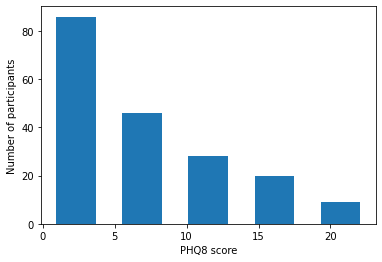

<Figure size 432x288 with 0 Axes>

In [ ]:
bins=[-1,0,5,10,15,25]
plt.figure()
plt.hist(ds_total["PHQ8_Score"], rwidth=0.6, bins=5)
plt.xlabel('PHQ8 score')
plt.ylabel('Number of participants')
plt.show()
plt.savefig('/content/drive/My Drive/Depression_detect/bins.png')


### Splitting the dataset and grouping them based on the 5 different level

In [ ]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [ ]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


## Random Sampling to overcome Imbalance

In [ ]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])

In [ ]:
ds_= ds_total_b.to_csv('ds_total_b.csv')

### Merging the phrases_lp (consisting of the transcripts) and ds_total consisting of PHQ Score

In [ ]:
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp.drop(ds_lp[ds_lp["t_answer"].map(len) < 10].index, inplace = True)
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b.drop(ds_lp_b[ds_lp_b["t_answer"].map(len) < 10].index, inplace = True)

In [ ]:
#ds_lp["t_answer"][142810]

In [ ]:
(len(ds_lp))

141137

### Splitting ds_total into train, dev and test in the ratio of 70:14:16

In [ ]:
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

In [ ]:

train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

### Creating a confusion matrix which consists of the TPs, TNs, FPs and FNs of the predicted labels for the transcripts

In [ ]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

### Loading the Glove Embeddings into a file and putting each vector into an np array

In [ ]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


### Creating a embedding matrix

In [ ]:

def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index) # tokenizer.word_index is the list that consist of all the unique words
    embedding_matrix = np.zeros((vocab_size+1, 100)) # creating an embedding matrix
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

### calling the embedding matrix function for creating vectors for each unique word

In [ ]:
embedding_matrix_lp = fill_embedding_matrix(tokenizer)
embedding_matrix_lp.shape

(7450, 100)

In [ ]:
train_lp['t_answer']
train_lp.head()

,Participant_ID,level,cat_level,PHQ8_Score,Gender,Unnamed: 0,personId,answer,t_answer
95368,464.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,1,122008,464,"['that', 'pretty', 'much', 'temper', 'try', 'm...","[20, 23, 32, 218, 62, 45, 329, 4, 5, 740]"
50399,363.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,1,41094,363,"['am', 'child', 'like', 'around', 'good', 'lat...","[6, 112, 5, 91, 16, 453, 468, 887, 26, 593]"
115332,361.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,1,39697,361,"['social', 'person', 'um', 'nothing', 'much', ...","[429, 71, 1, 174, 32, 35, 2, 51, 2, 45]"
127008,411.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,83734,411,"['strong', 'decision', 'usually', 'decision', ...","[445, 105, 126, 105, 100, 5622, 1223, 3852, 12..."
25358,492.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,142367,492,"['iphone', 'yeah', 'depends', 'situation', 'i'...","[5950, 11, 233, 89, 3, 6, 155, 322, 714, 30]"


In [ ]:
train_a =np.stack(train_lp['t_answer'])
dev_a = np.stack(dev_lp['t_answer'])
train_y = np.stack(train_lp['cat_level'], axis=0) 
dev_y = np.stack(dev_lp['cat_level'], axis=0)

In [ ]:
dev_a.shape

(19760, 10)

### stacking all the arrays together to form a single array

In [ ]:
train_a_b = np.stack(train_lp_b['t_answer'], axis=0)
dev_a_b = np.stack(dev_lp_b['t_answer'], axis=0)
train_y_b = np.stack(train_lp_b['cat_level'], axis=0)
dev_y_b = np.stack(dev_lp_b['cat_level'], axis=0)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

### creating function for plotting the loss and accuracies of the models

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

### answer_emb1 is the input consisting of the vectors having a window size of 10

In [ ]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)



### GLoVE + LSTM (imbalanced) MODEL

In [ ]:
bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(5,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           25856     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 256)           65792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0   

In [ ]:
model_glove_lstm_hist = model.fit(train_a, train_y, validation_data=(dev_a, dev_y), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 98795 samples, validate on 19760 samples
Epoch 1/30
98795/98795 [==============================] - 50s 503us/step - loss: 1.4525 - accuracy: 0.3747 - val_loss: 1.3414 - val_accuracy: 0.4367
Epoch 2/30
98795/98795 [==============================] - 49s 493us/step - loss: 1.2671 - accuracy: 0.4734 - val_loss: 1.1069 - val_accuracy: 0.5646
Epoch 3/30
98795/98795 [==============================] - 49s 498us/step - loss: 1.1056 - accuracy: 0.5524 - val_loss: 0.9235 - val_accuracy: 0.6487
Epoch 4/30
98795/98795 [==============================] - 54s 547us/step - loss: 0.9935 - accuracy: 0.6020 - val_loss: 0.8078 - val_accuracy: 0.6917
Epoch 5/30
98795/98795 [==============================] - 49s 498us/step - loss: 0.9198 - accuracy: 0.6371 - val_loss: 0.6993 - val_accuracy: 0.7409
Epoch 6/30
98795/98795 [==============================] - 49s 501us/step - loss: 0.8533 - accuracy: 0.6666 - val_loss: 0.6363 - val_accuracy: 0.7638
Epoch 7/30
98795/98795 [==============================] 

In [ ]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
#df_confusion1 = confusion_matrix(model, test_a, test_y)

In [ ]:
df_confusion1

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3359,106,47,18,26
mild,62,7437,143,48,46
moderate,64,199,5731,43,55
moderately severe,28,83,66,2608,24
severe,25,37,37,24,2266


In [ ]:
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16040187424668892
Test accuracy: 0.9477016925811768


In [ ]:
from sklearn.externals import joblib
joblib.dump(model,"model.pkl"),

(['model.pkl'],)

## **LSTM Model for the balanced dataset**

In [ ]:
model_glove_lstm_hist_b = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 64179 samples, validate on 12836 samples
Epoch 1/30
64179/64179 [==============================] - 31s 484us/step - loss: 0.3943 - accuracy: 0.8577 - val_loss: 0.0728 - val_accuracy: 0.9825
Epoch 2/30
64179/64179 [==============================] - 31s 486us/step - loss: 0.3426 - accuracy: 0.8763 - val_loss: 0.0662 - val_accuracy: 0.9829
Epoch 3/30
64179/64179 [==============================] - 31s 489us/step - loss: 0.3222 - accuracy: 0.8842 - val_loss: 0.0651 - val_accuracy: 0.9847
Epoch 4/30
64179/64179 [==============================] - 32s 501us/step - loss: 0.2973 - accuracy: 0.8929 - val_loss: 0.0545 - val_accuracy: 0.9863
Epoch 5/30
64179/64179 [==============================] - 32s 493us/step - loss: 0.2929 - accuracy: 0.8952 - val_loss: 0.0523 - val_accuracy: 0.9874
Epoch 6/30
64179/64179 [==============================] - 32s 494us/step - loss: 0.2762 - accuracy: 0.9002 - val_loss: 0.0541 - val_accuracy: 0.9861
Epoch 7/30
64179/64179 [==============================] 

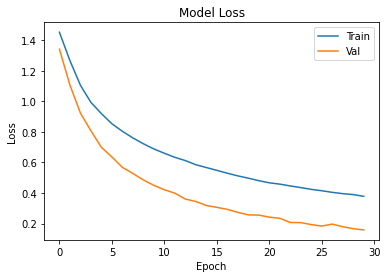

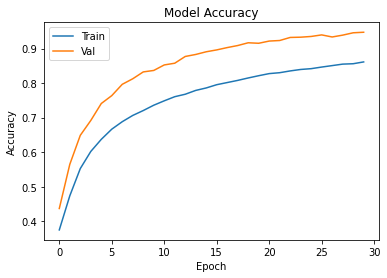

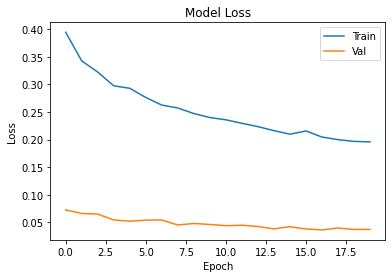

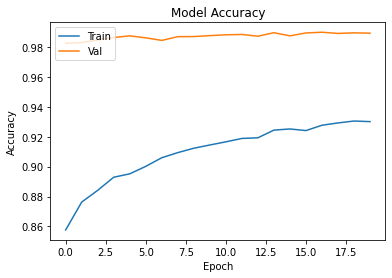

In [ ]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)
plot_loss(model_glove_lstm_hist_b)
plot_acc(model_glove_lstm_hist_b)

In [ ]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a_b, test_y_b)

In [ ]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3524,5,11,11,5
mild,24,2903,8,15,9
moderate,13,5,2916,15,8
moderately severe,12,3,3,2782,9
severe,7,2,5,8,2367


In [ ]:
score = model.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03850240387929059
Test accuracy: 0.9878664016723633


In [ ]:
model.save('/content/drive/My Drive/Depression_detect/model_glove_lstm_b.h5')

with open('/content/drive/My Drive/Depression_detect/model_glove_lstm_b_hist.json', 'w') as f:
    json.dump(str(model_glove_lstm_hist.history), f)

In [ ]:
def test_model(text,model):
    print(text)
    word_list = text_to_wordlist(text)
    sequences = tokenizer.texts_to_sequences([word_list])
    sequences_input = list(itertools.chain(*sequences))
    sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
    print(sequences_input)
    input_a = np.asarray(sequences_input)
    pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
    predicted_class = np.argmax(pred)
    print(labels[predicted_class])

In [ ]:
text= "I want an ice cream and have some fries for lunch"
test_model(text, model)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model)
sen = "I am a graduate student"
test_model(sen, model)
sen = "I am getting married"
test_model(sen, model)
sen = "This party is great, I know lots of people"
test_model(sen, model)
sen = "I miss my parents, brothers and sisters"
test_model(sen, model)
sen = "I detest my horrible job"
test_model(sen, model)
sen = "I cannot handle this anymore"
test_model(sen, model)

I want an ice cream and have some fries for lunch
[[193, 2438, 2825, 6594, 4186, 0, 0, 0, 0, 0]]
severe
I'm afraid of losing my work, I don't have any money
[[1, 18, 780, 908, 108, 211, 0, 0, 0, 0]]
none
I'm worried about my future, I'm afraid of it
[[1, 18, 1070, 566, 1, 18, 780, 0, 0, 0]]
mild
I am a graduate student
[[833, 967, 0, 0, 0, 0, 0, 0, 0, 0]]
none
I am getting married
[[147, 440, 0, 0, 0, 0, 0, 0, 0, 0]]
none
This party is great, I know lots of people
[[563, 150, 14, 51, 39, 0, 0, 0, 0, 0]]
none
I miss my parents, brothers and sisters
[[602, 3832, 294, 291, 0, 0, 0, 0, 0, 0]]
none
I detest my horrible job
[[860, 123, 0, 0, 0, 0, 0, 0, 0, 0]]
none
I cannot handle this anymore
[[127, 537, 369, 0, 0, 0, 0, 0, 0, 0]]
none


## MODEL 2  word2vec + 2LSTMs

In [ ]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


lstm1 = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(answer_emb1)
lstm2 = LSTM(embedding_size_glove, dropout=0.2, recurrent_dropout=0.2)(lstm1)

X = Dropout(0.2)(lstm2)
bt = BatchNormalization()(X)
dense1 = Dense(units=256, activation="relu")(bt)

out = Dense(5,  activation='softmax')(dense1)

model_2lstm = Model(inputs=[answer_inp], outputs=[out])
model_2lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_2lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2585

In [ ]:
model_glove_2lstm_b_hist = model_2lstm.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 64179 samples, validate on 12836 samples
Epoch 1/30
64179/64179 [==============================] - 36s 558us/step - loss: 1.6247 - accuracy: 0.2333 - val_loss: 1.5864 - val_accuracy: 0.2562
Epoch 2/30
64179/64179 [==============================] - 35s 546us/step - loss: 1.5833 - accuracy: 0.2651 - val_loss: 1.5531 - val_accuracy: 0.2901
Epoch 3/30
64179/64179 [==============================] - 35s 551us/step - loss: 1.5498 - accuracy: 0.2982 - val_loss: 1.5092 - val_accuracy: 0.3378
Epoch 4/30
64179/64179 [==============================] - 39s 605us/step - loss: 1.4980 - accuracy: 0.3374 - val_loss: 1.4387 - val_accuracy: 0.3942
Epoch 5/30
64179/64179 [==============================] - 35s 551us/step - loss: 1.4238 - accuracy: 0.3877 - val_loss: 1.3620 - val_accuracy: 0.4145
Epoch 6/30
64179/64179 [==============================] - 35s 550us/step - loss: 1.3562 - accuracy: 0.4299 - val_loss: 1.2502 - val_accuracy: 0.4956
Epoch 7/30
64179/64179 [==============================] 

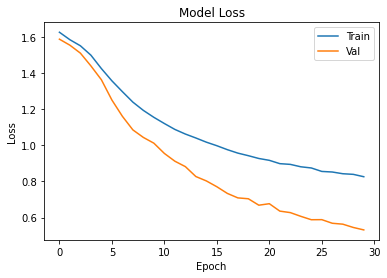

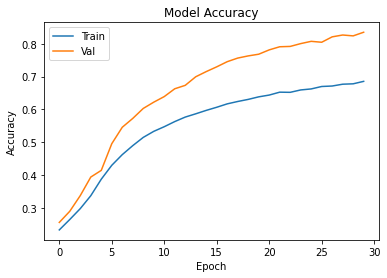

In [ ]:
plot_loss(model_glove_2lstm_b_hist)
plot_acc(model_glove_2lstm_b_hist)


In [ ]:

score = model_2lstm.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5319803232267428
Test accuracy: 0.8332651853561401


In [ ]:
df_confusion = confusion_matrix(model_2lstm, test_a_b, test_y_b)

In [ ]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,2999,168,160,136,93
mild,181,2458,99,125,96
moderate,153,124,2477,126,77
moderately severe,143,117,124,2334,91
severe,99,95,98,141,1956


In [ ]:
#model_2lstm.save('/content/drive/My Drive/Depression_detect/model_glove_2lstm_b.h5')

#with open('/content/drive/My Drive/Depression_detect/model_glove_2lstm_b_hist.json', 'w') as f:
    #json.dump(model_glove_2lstm_b_hist.history, f)

In [ ]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_2lstm)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_2lstm)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model_2lstm)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model_2lstm)
sen = "My father loves me"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
[[90, 99, 563, 1, 18, 128, 14, 136, 39, 0]]
moderately severe
I want an ice cream and have some fries for lunch
[[193, 2438, 2825, 6594, 4186, 0, 0, 0, 0, 0]]
moderate
I'm afraid of losing my work, I don't have any money
[[1, 18, 780, 908, 108, 211, 0, 0, 0, 0]]
none
I'm worried about my future, I'm afraid of it
[[1, 18, 1070, 566, 1, 18, 780, 0, 0, 0]]
severe
My father loves me
[[339, 119, 0, 0, 0, 0, 0, 0, 0, 0]]
none


## MODEL 3 Bidirectional LSTM

In [ ]:
# main model
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


bi_lstm =  Bidirectional (LSTM (embedding_size_glove,return_sequences=True,dropout=0.50),merge_mode='concat')(answer_emb1)
model_bi1 = TimeDistributed(Dense(embedding_size_glove,activation='relu'))(bi_lstm) #TimeDistributed method is used to apply a Dense layer to each of the time-steps independently. We used Dropout and l2_reg regularizers to reduce overfitting.
model_bi2 = Flatten()(model_bi1)
model_bi3 = Dense(256,activation='relu')(model_bi2)
output = Dense(5,activation='softmax')(model_bi3)
model_bi = Model(answer_inp,output)
model_bi.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 100)           20100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1285

In [ ]:
model_glove_bilstm = model_bi.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 64179 samples, validate on 12836 samples
Epoch 1/30
64179/64179 [==============================] - 39s 604us/step - loss: 1.5946 - accuracy: 0.2473 - val_loss: 1.5790 - val_accuracy: 0.2725
Epoch 2/30
64179/64179 [==============================] - 38s 589us/step - loss: 1.5737 - accuracy: 0.2722 - val_loss: 1.5499 - val_accuracy: 0.2969
Epoch 3/30
64179/64179 [==============================] - 38s 586us/step - loss: 1.5495 - accuracy: 0.2983 - val_loss: 1.5145 - val_accuracy: 0.3278
Epoch 4/30
64179/64179 [==============================] - 37s 582us/step - loss: 1.5102 - accuracy: 0.3291 - val_loss: 1.4509 - val_accuracy: 0.3706
Epoch 5/30
64179/64179 [==============================] - 37s 580us/step - loss: 1.4489 - accuracy: 0.3710 - val_loss: 1.3726 - val_accuracy: 0.4159
Epoch 6/30
64179/64179 [==============================] - 37s 582us/step - loss: 1.3907 - accuracy: 0.4070 - val_loss: 1.2974 - val_accuracy: 0.4655
Epoch 7/30
64179/64179 [==============================] 

In [ ]:
# evaluate the model
score = model_bi.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9042176990014968
Test accuracy: 0.6584185361862183


### Model 4 Using BiGRU 

In [ ]:
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings.

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [ ]:
# main model
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

x = SpatialDropout1D(0.2)(answer_emb1)
x = Bidirectional(GRU(embedding_size_glove, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation="softmax")(conc)
    
model_gru = Model(inputs=answer_inp, outputs=outp)
model_gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 100)      745000      input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 10, 100)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 10, 200)      120600      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
batch_size = 64
epochs = 30
RocAuc = RocAucEvaluation(validation_data=(dev_a,dev_y), interval=1)

In [ ]:
hist = model_gru.fit(train_a, train_y, batch_size=batch_size, epochs=epochs, validation_data=(dev_a, dev_y),
                 callbacks=[RocAuc], verbose=2)

Train on 98795 samples, validate on 19760 samples
Epoch 1/30
 - 57s - loss: 1.4763 - accuracy: 0.3617 - val_loss: 1.4134 - val_accuracy: 0.4016

 ROC-AUC - epoch: 1 - score: 0.673696 

Epoch 2/30
 - 53s - loss: 1.3791 - accuracy: 0.4203 - val_loss: 1.2791 - val_accuracy: 0.4897

 ROC-AUC - epoch: 2 - score: 0.764619 

Epoch 3/30
 - 53s - loss: 1.2513 - accuracy: 0.4923 - val_loss: 1.1299 - val_accuracy: 0.5592

 ROC-AUC - epoch: 3 - score: 0.828097 

Epoch 4/30
 - 53s - loss: 1.1308 - accuracy: 0.5519 - val_loss: 1.0039 - val_accuracy: 0.6262

 ROC-AUC - epoch: 4 - score: 0.870184 

Epoch 5/30
 - 53s - loss: 1.0317 - accuracy: 0.5975 - val_loss: 0.9016 - val_accuracy: 0.6695

 ROC-AUC - epoch: 5 - score: 0.897007 

Epoch 6/30
 - 53s - loss: 0.9500 - accuracy: 0.6332 - val_loss: 0.8216 - val_accuracy: 0.6997

 ROC-AUC - epoch: 6 - score: 0.915946 

Epoch 7/30
 - 53s - loss: 0.8877 - accuracy: 0.6596 - val_loss: 0.7375 - val_accuracy: 0.7352

 ROC-AUC - epoch: 7 - score: 0.932660 

Epoch

In [ ]:
# evaluate the model
score = model_gru.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20535954314892846
Test accuracy: 0.938513994216919


## Model - 5 CNN

In [ ]:
filter_sizes = [1,2,3,5]
num_filters = 36
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)
x = Reshape((windows_size, embedding_size_glove, 1))(answer_emb1) #Initializers allow you to pre-specify an initialization strategy, encoded in the Initializer object, without knowing the shape and dtype of the variable being initialized.
maxpool_pool = []
for i in range(len(filter_sizes)):
  conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embedding_size_glove),kernel_initializer='he_normal', activation='relu')(x)
  maxpool_pool.append(MaxPool2D(pool_size=(windows_size - filter_sizes[i] + 1, 1))(conv))

z = Concatenate(axis=1)(maxpool_pool)   
z = Flatten()(z)
z = Dropout(0.1)(z)

outp = Dense(5, activation="softmax")(z)

model = Model(inputs=answer_inp, outputs=outp)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      745000      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 10, 100, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 1, 36)    3636        reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
model_cnn =  model.fit(train_a, train_y, batch_size=64, epochs=30, validation_data=(dev_a, dev_y), verbose=2,callbacks=[early_stopping])

Train on 98795 samples, validate on 19760 samples
Epoch 1/30
 - 15s - loss: 1.4580 - accuracy: 0.3806 - val_loss: 1.3410 - val_accuracy: 0.4472
Epoch 2/30
 - 15s - loss: 1.2535 - accuracy: 0.4903 - val_loss: 1.1902 - val_accuracy: 0.5317
Epoch 3/30
 - 15s - loss: 1.0951 - accuracy: 0.5663 - val_loss: 1.0708 - val_accuracy: 0.5786
Epoch 4/30
 - 15s - loss: 0.9823 - accuracy: 0.6151 - val_loss: 0.9857 - val_accuracy: 0.6177
Epoch 5/30
 - 15s - loss: 0.9055 - accuracy: 0.6497 - val_loss: 0.9770 - val_accuracy: 0.6227
Epoch 6/30
 - 15s - loss: 0.8471 - accuracy: 0.6724 - val_loss: 0.8788 - val_accuracy: 0.6635
Epoch 7/30
 - 15s - loss: 0.8037 - accuracy: 0.6909 - val_loss: 0.8746 - val_accuracy: 0.6580
Epoch 8/30
 - 15s - loss: 0.7680 - accuracy: 0.7047 - val_loss: 0.8537 - val_accuracy: 0.6692
Epoch 9/30
 - 15s - loss: 0.7418 - accuracy: 0.7145 - val_loss: 0.7819 - val_accuracy: 0.7024
Epoch 10/30
 - 19s - loss: 0.7177 - accuracy: 0.7247 - val_loss: 0.8304 - val_accuracy: 0.6779
Epoch 11/

In [ ]:
# evaluate the model
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5834497151177596
Test accuracy: 0.7813302874565125


## Model 6- CNN + LSTM (Hybrid Model)

In [ ]:
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(vocab_size_stop+1, 100,weights=[embedding_matrix_lp],input_length=windows_size, trainable=False))
lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) #We can use a smallish set of 32 features with a small filter length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(LSTM(100))
lstm_cnn.add(Dense(5, activation='softmax'))
lstm_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
lstm_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 32)            9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 808,337
Trainable params: 63,337
Non-trainable params: 745,000
_________________________________________________________________


In [ ]:
hist = lstm_cnn.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 65939 samples, validate on 13189 samples
Epoch 1/30
65939/65939 [==============================] - 11s 171us/step - loss: 1.5373 - accuracy: 0.3087 - val_loss: 1.4574 - val_accuracy: 0.3735
Epoch 2/30
65939/65939 [==============================] - 11s 167us/step - loss: 1.3688 - accuracy: 0.4252 - val_loss: 1.3136 - val_accuracy: 0.4594
Epoch 3/30
65939/65939 [==============================] - 11s 166us/step - loss: 1.2345 - accuracy: 0.4990 - val_loss: 1.2511 - val_accuracy: 0.4927
Epoch 4/30
65939/65939 [==============================] - 11s 171us/step - loss: 1.1432 - accuracy: 0.5432 - val_loss: 1.1811 - val_accuracy: 0.5275
Epoch 5/30
65939/65939 [==============================] - 11s 167us/step - loss: 1.0780 - accuracy: 0.5733 - val_loss: 1.1505 - val_accuracy: 0.5377
Epoch 6/30
65939/65939 [==============================] - 11s 165us/step - loss: 1.0231 - accuracy: 0.5991 - val_loss: 1.1213 - val_accuracy: 0.5530
Epoch 7/30
65939/65939 [==============================] 

In [ ]:
# evaluate the model
score = lstm_cnn.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9602536167393505
Test accuracy: 0.6658926606178284


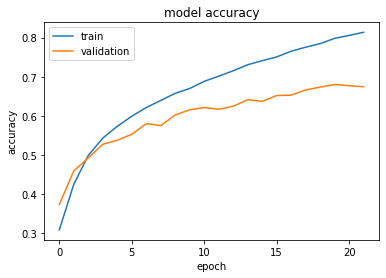

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

![alt text](https://)## Model 7- BiLSTM + Attention

In [ ]:
from keras import backend as K
lstm_units = 128

in_text = Input(shape=(windows_size, ))
embedding_layer = Embedding(vocab_size_stop+1,
                        100,
                        weights=[embedding_matrix_lp],
                        input_length=windows_size,
                        trainable=False)
x = embedded_sequences = embedding_layer(in_text)
bilstm = Bidirectional(LSTM(lstm_units,return_sequences=True, dropout=0.3, recurrent_dropout=0.25))(x)  
attention = TimeDistributed(Dense(1,activation='tanh'))(bilstm)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(2*lstm_units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = multiply([bilstm, attention])
out_text = Lambda(lambda xin: K.sum(xin, axis= 1), output_shape=(2*lstm_units,), name='sent')(sent_representation) 

output_ = Dense(5, activation='softmax')(out_text) 

bilstm_attn = Model(inputs=in_text, outputs= output_) 
bilstm_attn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_attn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 10, 100)      745000      input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 10, 256)      234496      embedding_5[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 1)        257         bidirectional_19[0][0]           
____________________________________________________________________________________________

In [ ]:
history = bilstm_attn.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True)

Train on 65969 samples, validate on 13195 samples
Epoch 1/30
65969/65969 [==============================] - 67s 1ms/step - loss: 1.5746 - accuracy: 0.2735 - val_loss: 1.5460 - val_accuracy: 0.2947
Epoch 2/30
65969/65969 [==============================] - 66s 1ms/step - loss: 1.5315 - accuracy: 0.3152 - val_loss: 1.4772 - val_accuracy: 0.3541
Epoch 3/30
65969/65969 [==============================] - 66s 998us/step - loss: 1.4539 - accuracy: 0.3724 - val_loss: 1.3581 - val_accuracy: 0.4390
Epoch 4/30
65969/65969 [==============================] - 66s 1ms/step - loss: 1.3484 - accuracy: 0.4341 - val_loss: 1.2382 - val_accuracy: 0.5060
Epoch 5/30
65969/65969 [==============================] - 67s 1ms/step - loss: 1.2444 - accuracy: 0.4919 - val_loss: 1.1044 - val_accuracy: 0.5736
Epoch 6/30
65969/65969 [==============================] - 67s 1ms/step - loss: 1.1513 - accuracy: 0.5395 - val_loss: 0.9962 - val_accuracy: 0.6255
Epoch 7/30
65969/65969 [==============================] - 66s 1ms/

In [ ]:
# evaluate the model
score = bilstm_attn.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.207232202045702
Test accuracy: 0.9411764740943909


In [ ]:
from keras.layers import Dense, Input,LSTM,Embedding, Dropout, Activation, Conv1D,RepeatVector, Permute, Multiply
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:

class AttentionLayer(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self, **kwargs):
        self.init = initializers.get('glorot_uniform')
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer=self.init,
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(input_shape[-1], ),
                                 initializer=self.init,
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(input_shape[-1], 1),
                                 initializer=self.init,
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        
       #Through structure the vector applied  is used as
        #Make attention value into probability distribution through
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])


In [ ]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

In [ ]:
lstm_dim=50
bilstm = Bidirectional(LSTM(lstm_dim, return_sequences=True))(answer_emb1)  #Input should be three dimensional
# bilstm = LSTM(2*lstm_dim, return_sequences=True)(input_data) 
# bilstm_output = Dense(1)(bilstm)

attention_layer = AttentionLayer()(bilstm)
print(attention_layer)
repeated_word_attention = RepeatVector(lstm_dim * 2)(attention_layer)
repeated_word_attention = Permute([2, 1])(repeated_word_attention)
sentence_representation = Multiply()([bilstm, repeated_word_attention])
sentence_representation = Lambda(lambda x: K.sum(x, axis=1))(sentence_representation) #total summation of the multiplied bilstm and attention 

bilstm_output = Dense(5,activation='softmax')(sentence_representation)

model = Model(inputs=[answer_inp],
            outputs=[bilstm_output])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])



Tensor("attention_layer_7/Softmax:0", shape=(?, 10), dtype=float32)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 100)      745000      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 10, 100)      60400       embedding_4[0][0]                
__________________________________________________________________________________________________
attention_layer_7 (AttentionLay (None, 10)           10200       bidirectional_18[0][0]           
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True)

Train on 65969 samples, validate on 13195 samples
Epoch 1/30
65969/65969 [==============================] - 23s 349us/step - loss: 1.5496 - accuracy: 0.2982 - val_loss: 1.4944 - val_accuracy: 0.3444
Epoch 2/30
65969/65969 [==============================] - 22s 339us/step - loss: 1.4263 - accuracy: 0.3918 - val_loss: 1.3625 - val_accuracy: 0.4337
Epoch 3/30
65969/65969 [==============================] - 22s 336us/step - loss: 1.2535 - accuracy: 0.4949 - val_loss: 1.2268 - val_accuracy: 0.5076
Epoch 4/30
65969/65969 [==============================] - 22s 335us/step - loss: 1.0769 - accuracy: 0.5841 - val_loss: 1.0899 - val_accuracy: 0.5773
Epoch 5/30
65969/65969 [==============================] - 22s 334us/step - loss: 0.9249 - accuracy: 0.6551 - val_loss: 1.0196 - val_accuracy: 0.6090
Epoch 6/30
65969/65969 [==============================] - 22s 335us/step - loss: 0.7952 - accuracy: 0.7120 - val_loss: 0.8914 - val_accuracy: 0.6676
Epoch 7/30
65969/65969 [==============================] 

In [ ]:
# evaluate the model
score = model.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.502733766115568
Test accuracy: 0.8649114370346069
